# 베타분포를 이용한 사망률계산

'COVID-19' 로 인해서 전세계가 혼란스러운 상황이다. 일부 국가에서만 발생하던 상황에서 전세계로 확산이 되어가고 있다. 같은 바이러스 이지만 국가간 진행되는 양상은 조금씩 달라보인다. 그 중에서 **사망률** 에 대해서 국가간의 비교를 해보려고 한다.

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
!pip install arviz==0.6.0
import arviz as az
import seaborn as sns
import scipy

import warnings 
from theano import tensor as tt
warnings.filterwarnings('ignore')

In [0]:
# 데이터 입력
c = pd.read_csv('time_series_19-covid-Confirmed.csv')
d = pd.read_csv('time_series_19-covid-Deaths.csv')

In [0]:
# 감염자 100명 이상인 나라만 대상
c = c.groupby('Country/Region').sum().iloc[:,2:]
d = d.groupby('Country/Region').sum().iloc[:,2:]

c = c.loc[c.iloc[:,-1]>100]
d = d.loc[d.index.isin(c.index)]

In [0]:
# 사망률
drate = d/c

In [248]:
# 3/12 현재 감염자 100명 이상인 나라는
print('Number of Confirmed more than 100 : ', c.shape[0],'countries')
print('-->', c.iloc[:,-1].sort_values(ascending=False).index[:5].values)
print('Number of Deaths more than 50 : ', d[d.iloc[:,-1]>50].shape[0],'countries')
print('-->', d.iloc[:,-1].sort_values(ascending=False).index[:5].values)

Number of Confirmed more than 100 :  25 countries
--> ['China' 'Italy' 'Iran' 'Korea, South' 'US']
Number of Deaths more than 50 :  6 countries
--> ['China' 'Italy' 'Iran' 'US' 'Korea, South']


In [249]:
# 감염자 100명 이상 중 사망률 순위
print('-- top death rate --')
print(drate.iloc[:,-1].sort_values(ascending=False).head(5))

-- top death rate --
Country/Region
Italy    0.066362
Iran     0.039333
China    0.039063
US       0.028523
Spain    0.023715
Name: 3/11/20, dtype: float64


In [0]:
# table 정리
lookup_table = c.iloc[:,-1].sort_values(ascending=False).reset_index().rename(columns={'3/11/20':'confirmed'})
lookup_table = lookup_table.join(d.iloc[:,-1], on='Country/Region').rename(columns={'3/11/20': 'death'})

# 일일 집계
dc = c - c.shift(1, axis=1)
dd = d - d.shift(1, axis=1)

In [274]:
# 감염자 기준 정렬
lookup_table

,Country/Region,confirmed,death
0,China,80921,3161
1,Italy,12462,827
2,Iran,9000,354
3,"Korea, South",7755,60
4,US,2384,68
5,France,2284,48
6,Spain,2277,54
7,Germany,1908,3
8,Cruise Ship,696,7
9,Switzerland,652,4


## 1. 베타분포
베타 분포는 binary값을 가지는 베르누이 분포와 conjugate 한 성질을 가지고 있다. 그렇기에 분포를 추론하기에 이점이 있는 함수이다. 확진자가 있을 때, 확진자의 상태는 생존/사망 두가지의 상태로 나뉜다. 베르누이 시행이다. 
<br>
모수는 $\alpha$, $\beta$ 두가지를 가지며 이 두 모수를 통해서 분포의 형태가 결정된다.

#### **베타분포의 업데이트**
![beta](https://www.researchgate.net/publication/268520286/figure/fig3/AS:670023416836097@1536757439123/Beta-distribution-Each-window-shows-the-shape-of-the-beta-distribution-for-different.png)

베타분포는 아주 직관적인 함수이다. 몇가지 특징은 다음과 같다
* 모수인 $\alpha$,$\beta$ 가 같으면 중앙을 기준으로 좌우 대칭인 형태를 띈다.
* $\alpha$ + $\beta$ 의 값이 커지면 분포의 분산이 줄어들고 뾰족한 형태가 된다.
* $\alpha$ 값이 커지면 1로 가까워 지고 , $\beta$가 커지면 0으로 가까워진다.
<br>

예를들어서 $\alpha$=1, $\beta$=1 인상태에서 $\alpha$를 사망자수, $\beta$를 생존자수라고 생각을 해보자. $\alpha$가 커지면 1로 가까워진다. 사망률이 높아진다는 의미이다. 반대로 $\beta$가 커지면 분포가 0에 가까워지고 사망률이 떨어진다는 의미로 이해할 수 있다.
<br>



## 2.사망률 추이
국내 확진자수 및 사망자수를 이용하여 베타함수의 변화추이를 살펴보자.

In [0]:
# 사망률 업데이트 및 베타분포 추정함수.
class Drate:
    """
    업데이트 및 베타함수 확률변수 반환
    """
    def __init__(self, t_df, d_df):
        
        self.length = t_df.shape[0] 
        self.tpoint = t_df.shape[1]
        self._input1 = t_df
        self._input2 = d_df

        self.death = np.array(d_df)
        self.total = np.array(t_df)
        self.normal = self.total - self.death

        self.alpha = np.ones((self.length, self.tpoint))
        self.beta = np.ones((self.length, self.tpoint))

        self.totalsum = t_df.iloc[:,-1].sum()     
        self.deathsum = d_df.iloc[:,-1].sum()     
    def update(self):

        self.alpha +=  self.death
        self.beta += self.normal
       
    def param(self, country, tpoint):
        location = self._input1
        location_country = int(np.where(location.index==country)[0])
        location_tpoint = tpoint
        beta = scipy.stats.beta(self.alpha[location_country,location_tpoint] , self.beta[location_country,location_tpoint])

        return beta

In [0]:
drate = Drate(c,d)
drate.update()

In [0]:
# 국내 사망률에 대한 beta확률변수 반환
y = drate.param('Korea, South',0)

In [0]:
# plotting 함수
def plot_priors(x, y, lw = 3, alpha = 0.2, xlim=1, label=country):
    
    p = plt.plot(x, y.pdf(x), lw = lw, label=label)
    color = p[0].get_markeredgecolor()
    plt.fill_between(x,y.pdf(x),0, color = color, alpha = alpha)
    max_x = np.argmax(y.pdf(x))/len(x)
    plt.vlines(max_x, 0 ,y.pdf(max_x) ,colors = color, linestyles = "--", lw = 2)
    plt.xlim(0,xlim)        
    return

In [287]:
# 처음으로 확진자 발생. index=29
np.where(d.loc['Korea, South']>0)

array([29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45,
       46, 47, 48, 49])

전염병 발생이후 29일에 처음으로 국내 사망자가 발생했다.

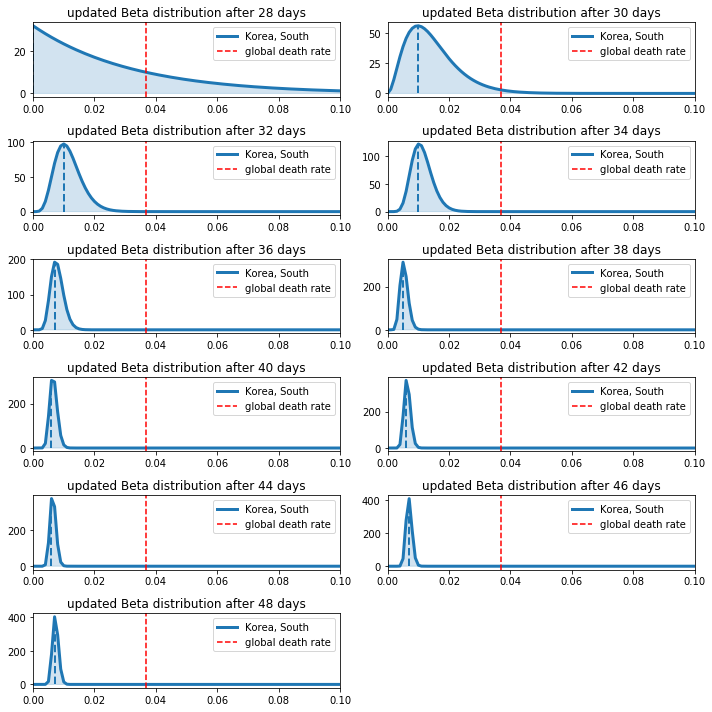

In [294]:
fig = plt.figure(figsize=(10, 10))
avg_x = a.deathsum/a.totalsum # 단순 세계평균 사망률
for j,i in enumerate(range(28,50,2)):
    x =  np.linspace(0,1,1000)
    y =  a.param('Korea, South', i)
    plt.subplot(6, 2, j+1) 
    plot_priors(x,y, xlim=0.1, label='Korea, South')
    plt.axvline(x=avg_x, ls='--', c='r', label='global death rate')
    plt.title('updated Beta distribution after %i days'%i)
    plt.legend()
plt.tight_layout()


국내 사망률은 전세계 사망률보다 한참 낮다. 확진자가 증가하면서 분포의 분산이 계속 줄어들고 있는 것이 보이고 그 만큼 사망률에 대한 확신이 강해지고 있음을 의미한다.

같은 방법으로 베타분포를 이용해 얻은 현재 감염자수 상위 10개국의 사망률은 다음과 같다.

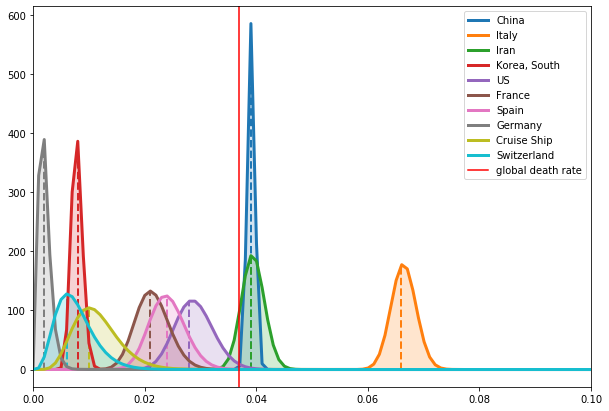

In [295]:
fig =plt.figure(figsize=(10,7))
for i in lookup_table['Country/Region'][:10]:
    x =  np.linspace(0,1,1000)
    y =  a.param(i, a.tpoint-1)
    plot_priors(x,y, xlim=0.1, label=i)
    
    
plt.axvline(x=avg_x, ls='-', c='r', label='global death rate')
plt.legend()

감염자수가 많은 나라들 예를들면 중국, 이탈리아, 한국의 경우는 분포의 형태가 뾰족하고 분산이 적은 반면 감염자수가 상대적으로 적은 나라들은 분산이 비교적 크다.

## 2.1 요약

베타분포의 직관적인 특징을 알 수 있다. 사망자수 대비 생존자수가 많기 때문에 베타분포의 모수인 $\beta$ 가 크고 그래서 0에 가까운 확률분포들이 나타난다. 또힌 $\alpha + \beta$ 인 감염자수가 증가할수록 형태가 뾰족해지고 평균이 집중되는 형태를 보여준다.

## 3. 실제 사망률은...

코로나 바이러스의 사망률은 초기에 3%라고 알려져 있었다. 위의 그림에서 보듯 비슷하게 수렴하는것 같은데 국가간의 편차가 큰것을 알 수가 있다. 어떤 나라는 예를들면 이탈리아의 경우 6%인 반면 한국의 0.7%이다. 같은 바이러스이지만 여러가지 요인에 의해 나라마다 사망률이 다르게 나타난다.
<br>


사망률을 어떻게 추정하는게 좋을까. 물론 사후적으로 평가하는것이 가장 정확하겠지만 그건 나중의 문제이고 현재 바이러스의 치명적인 정도를 알고싶다면 다음과 같은 방법들이 가능할 것 같다.
1. 전체 사망자/전체 감염자
2. 국가별 사망자/감염자
3. 평균을 반영한 국가간 사망률(?)



## 3.1 전체사망자/전체감염자

가장 간단한 방법이다. 현재 세계 사망자수 총합을 감염자수 총합으로 나누면 된다.

In [297]:
print('Global death rate : ',drate.deathsum/drate.totalsum)

Global death rate :  0.036925485935240594


대략 3.6%정도 나온다. 초기에 발표되었던 3%로와 근접한 수치이다. 베이지안의 방법으로 찾아본다면

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO (theano.gof.compilelock): Refreshing lock /root/.theano/compiledir_Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic-x86_64-3.6.9-64/lock_dir/lock
Sequential sampling (2 chains in 1 job)
NUTS: [p_observed]
100%|██████████| 4000/4000 [00:01<00:00, 2045.17it/s]
The acceptance probability does not match the target. It is 0.7210157099083085, but should be close to 0.8. Try to increase the number of tuning steps.


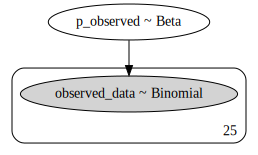

In [298]:
y = lookup_table['death'].values
countries = np.arange(len(lookup_table))
n = lookup_table['confirmed'].values

with pm.Model() as model1:

  p_observed = pm.Beta("p_observed", alpha=1, beta=1)
        
        
  observed_data = pm.Binomial("observed_data",
                             n = n,
                             p = p_observed, 
                             observed = y)
  trace1 = pm.sample(2000, tune=2000)
pm.model_to_graphviz(model1)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f481cc7db38>],
      dtype=object)

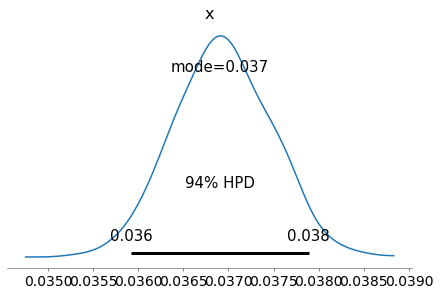

In [317]:
az.plot_posterior(trace1['p_observed'],point_estimate='mode')

사후분포는 0.37%를 평균으로 가지며 신뢰구간의 길이도 0.002로 강한 추정을 하고 있다.

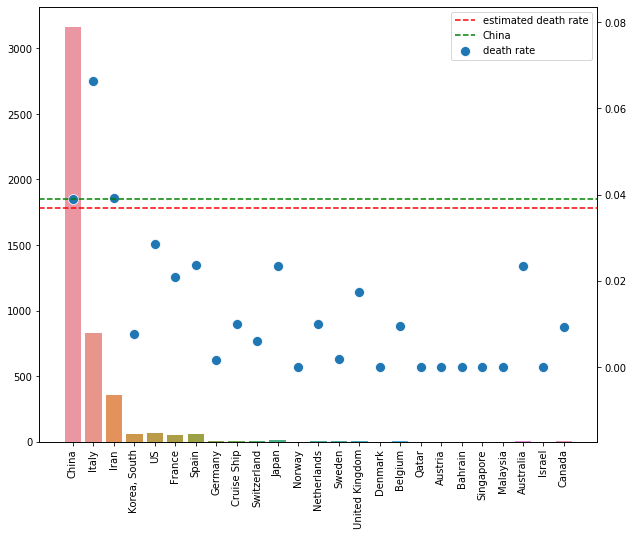

In [302]:
plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(x=lookup_table['Country/Region'].values,y = lookup_table['death'].values, label='number of death')
ax2 = plt.twinx()

sns.scatterplot(x=lookup_table['Country/Region'].values, y= (lookup_table['death']/lookup_table['confirmed']).values, ax=ax2, label='death rate', s=100)
plt.axhline(y=trace1['p_observed'].mean(), ls='--', c='r', label='estimated death rate')
plt.axhline(y=d.loc['China'][-1]/c.loc['China'][-1], ls='--', c='g', label='China')
plt.legend()
plt.show()

문제는 절대적으로 많은 중국의 통계치들이 전세계의 사망률 측정이 아주많이 반영이 되어있어서 개별 국가의 특징들이 다 죽어버렸다. **코로나 바이러스의 특징인지, 중국의 특징인지 분별하기 어렵다.**

## 3.2 국가별 개별 사망률

그러면 국가별로 따로따로 사망률을 계산하면 어떨까.
<br>
각 나라별 모수들을 따로따로 구해서 추정한다면 나라별 모델이 나올것이다

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_observed]
100%|██████████| 4000/4000 [00:04<00:00, 802.67it/s]


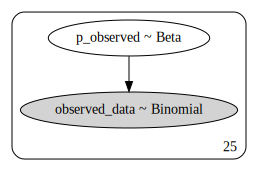

In [305]:
 with pm.Model() as model2:

  
  p_observed = pm.Beta("p_observed", alpha=1, beta=1, shape=25)

        
  observed_data = pm.Binomial("observed_data",
                             n = n,
                             p = p_observed[countries], 
                             observed = y)
  trace2 = pm.sample(2000, tune=2000)
pm.model_to_graphviz(model2)

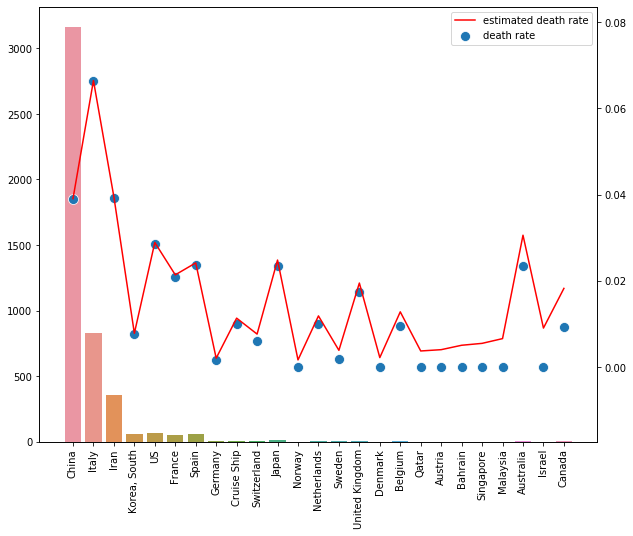

In [333]:
lookup_table['et2_mean'] = [ trace2['p_observed'][:,i].mean() for i in range(25)]


plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(x=lookup_table['Country/Region'].values,y = lookup_table['death'].values, label='number of death')
ax2 = plt.twinx()

sns.scatterplot(x=lookup_table['Country/Region'].values, y= (lookup_table['death']/lookup_table['confirmed']).values, ax=ax2, label='death rate', s=100)
plt.plot(lookup_table['et2_mean'], c='r', label='estimated death rate')


plt.legend()
plt.show()

국가별로 계산한 사망률 추정치는 다음과 같다. 이 추정치는 사후 분포의 평균치로 구할 수 있었다. 
<br>

아래는 감염자가 100명 이상인 나라를 추출했던 것에서 하위 10개국만 선별해서 분포를 그려본것이다.(그래프는 '2.베타분포' 에서 구했던 beta prior로 그렸다)

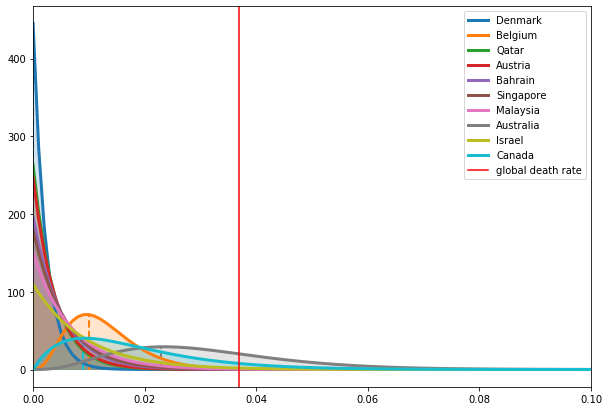

In [296]:
fig =plt.figure(figsize=(10,7))
for i in lookup_table['Country/Region'][-10:]:
    x =  np.linspace(0,1,1000)
    y =  a.param(i, a.tpoint-1)
    plot_priors(x,y, xlim=0.1, label=i)
    
    
plt.axvline(x=avg_x, ls='-', c='r', label='global death rate')
plt.legend()

감염수가 적은 나라들은 사망률을 추정하기에는 어려움이 있다. 아직 사망자가 존재하지 않은 나라들도 있다. 개별 나라별로 모델링을 하면 가장 밀도가 높은 **'Maximum a posteriori'** 지점은 0이 된다. 하지만 0인 사망률을 실제로 받아들이기는 어려움이 있다. **바이러스의 전반적인 특징이 반영되지 못했다.**

## 3.3 트렌드를 반영한 사망률

앞선 1,2 의 문제점은 이렇다.
* 3.1: 개별 특징이 죽는다
* 3.2: 전체 트렌드 특징이 죽는다.

이를 적절히 반영할 수 있는것이 바로 **partial pooling** 기법이다.우리는 나라마다 사망률이 조금씩 다를것이라는걸 알고 있다. 하지만 서로 다른 모수에서 나온 모델은 전체적인 트렌드의 경향이 무시되곤한다. 만약 각 나라별 모수들이 어떤 유사성을 공유한다면, 비슷한 경향성이 반영되지 않을까. 각각의 모수들이 어떤 동일한 분포에서 나온 값이라고 생각을 해보자.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [p_observed, beta, alpha]
100%|██████████| 4000/4000 [00:13<00:00, 288.23it/s]


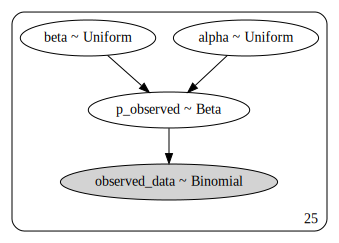

In [336]:
with pm.Model() as model3:
  
  alpha = pm.Uniform('alpha', lower=1, upper=50, shape=25)
  beta = pm.Uniform('beta', lower=1, upper=50, shape=25)

  p_observed = pm.Beta("p_observed", alpha=alpha[countries], beta=beta[countries], shape=25)

        
  observed_data = pm.Binomial("observed_data",
                             n = n,
                             p = p_observed[countries], 
                             observed = y)
  trace3 = pm.sample(2000 , tune=2000)
pm.model_to_graphviz(model3)

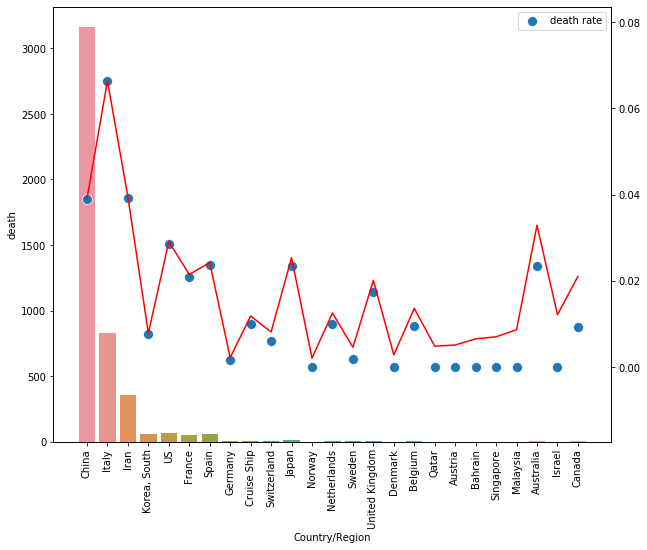

In [338]:
lookup_table['et3_mean'] = [trace3['p_observed'][:,i].mean() for i in range(25)]


plt.figure(figsize=(10,8))
plt.xticks(rotation=90)
sns.barplot(x=lookup_table['Country/Region'],y = lookup_table['death'], label='number of death')
ax2 = plt.twinx()

sns.scatterplot(x=lookup_table['Country/Region'], y= lookup_table['death']/lookup_table['confirmed'], ax=ax2, label='death rate', s=100)
plt.plot(lookup_table['et3_mean'], c='r')

plt.legend()
plt.show()

모델 그래프를 보면 층이 하나가 더 추가 됐다. 기존 3.1, 3.2 모델에서는 beta 분포의 모수 에 대해서 사전적으로 non-informative한 값을 부여했었다. 하지만 3.3 모델은 beta의 모수인 $\alpha, \beta$ 도 또다른 분포에서 나온 확률변수이다. 이렇게 계층적으로 연결되어 구성된 모델은 **hierarchical model(계층 모델)** 이라고 한다.

값을 보면 전반적으로 사망자수가 적은 나라들에서의 사망률의 값이 평균쪽으로 향하도록 보정이되었다.전반적인 트렌드가 반영이 됐다고 할 수 있다.(et2_mean:2번모델, et3_mean:3번모델) 미세하지만.. ㅎ

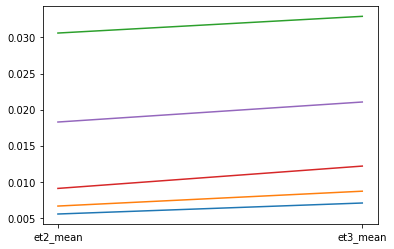

In [344]:
for i in range(20,25):
  plt.plot(lookup_table.iloc[i,-2:])